# Risk Management Demo

This notebook demonstrates:
1. Multi-asset portfolio backtesting
2. Risk Manager with different position sizing methods
3. Interactive risk dashboards
4. Comparison of sizing methods

## Features:
- **Position Sizing**: Equal weight, Fixed fraction, Kelly, Volatility-adjusted
- **Risk Limits**: Max position size, leverage, drawdown stops
- **Visualizations**: Interactive Plotly dashboards
- **Analysis**: Compare risk metrics across methods

In [1]:
# Setup: Add project root to path
import sys
from pathlib import Path

project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: /Users/Sakarias/QuantTrading


In [2]:
# Import required modules
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Core modules
from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from signals.momentum import MomentumSignalV2
from core.portfolio_manager import run_multi_asset_backtest, PortfolioConfig

# Risk management
from core.risk_manager import RiskManager, RiskConfig
from core.risk_dashboard import RiskDashboard

print("✅ All modules imported successfully")

✅ All modules imported successfully


## Step 1: Load Market Data

Load ES (S&P 500) and GC (Gold) futures data.

In [3]:
# Load data
tickers = ['ES', 'GC']
start_date = '2015-01-01'
end_date = '2025-11-05'


print(f"Loading data for {tickers}...")
prices = load_assets(tickers=tickers, start_date=start_date, end_date=end_date)

for ticker, df in prices.items():
    print(f"\n{ticker}: {len(df)} bars, {df.index[0].date()} to {df.index[-1].date()}")
    print(f"  Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

Loading data for ['ES', 'GC']...

Loading 2 assets: ['ES', 'GC']
✓ ES: 6134 rows, 2000-09-18 to 2024-12-31
✓ GC: 6106 rows, 2000-08-30 to 2024-12-31

Common date range: 2000-09-18 to 2024-12-31
Filtered date range: 2015-01-01 to 2024-12-31

Total unique dates: 2515
  GC: 2 missing dates, filled 2, 0 remain

ALIGNMENT SUMMARY
ES: 2515/2515 valid dates (100.0%)
GC: 2515/2515 valid dates (100.0%)

ES: 2515 bars, 2015-01-02 to 2024-12-31
  Price range: $1824.50 - $6099.00

GC: 2515 bars, 2015-01-02 to 2024-12-31
  Price range: $1050.80 - $2788.50


## Step 2: Generate Signals

Create momentum signals for each asset.

In [4]:
# Generate signals
signal_generator = MomentumSignalV2(lookback=120, sma_filter=200)
multi_signal = SingleAssetWrapper(signal_generator)
signals = multi_signal.generate(prices)

print(f"✓ Generated signals for {len(signals)} assets")
for ticker in tickers:
    sig = signals[ticker]['Signal']
    n_long = (sig == 1).sum()
    print(f"  {ticker}: {n_long} long days ({n_long/len(sig)*100:.1f}%)")

✓ Generated signals for 2 assets
  ES: 2216 long days (88.1%)
  GC: 2241 long days (89.1%)


## Step 3: Test Different Position Sizing Methods

Compare equal weight, fixed fraction, and volatility-adjusted sizing.

In [5]:
# Define sizing methods to test
sizing_methods = {
    'Equal Weight': {'method': 'equal_weight', 'max_position': 0.25},
    'Fixed 5%': {'method': 'fixed_fraction', 'max_position': 0.25, 'fixed_fraction': 0.05},
    'Vol Adjusted': {'method': 'vol_adjusted', 'max_position': 0.25, 'vol_target': 0.15}
}

results = {}

for method_name, params in sizing_methods.items():
    print(f"\n{'='*60}")
    print(f"Testing: {method_name}")
    print('='*60)
    
    # Create risk config
    risk_config = RiskConfig(
        position_sizing_method=params['method'],
        max_position_size=params['max_position'],
        max_leverage=1.0,
        max_drawdown_stop=-0.20,
        fixed_fraction=params.get('fixed_fraction', 0.02),
        volatility_target=params.get('vol_target', 0.15)
    )
    
    risk_mgr = RiskManager(risk_config)
    
    # Calculate and display position sizes
    print("\nPosition sizes:")
    for ticker in tickers:
        returns = prices[ticker]['Close'].pct_change().dropna()
        vol = risk_mgr.calculate_volatility(ticker, returns)
        
        pos_size = risk_mgr.calculate_position_size(
            ticker=ticker,
            signal=1.0,
            capital=100000,
            positions={},
            volatility=vol
        )
        
        print(f"  {ticker}: Vol={vol:.2%}, Size={pos_size:.2%}")
    
    # Run backtest
    config = PortfolioConfig(
        initial_capital=100000,
        rebalance_threshold=0.05,
        transaction_cost_bps=3.0
    )
    
    result, equity_df, trades_df = run_multi_asset_backtest(
        signals_dict=signals,
        prices_dict=prices,
        config=config,
        return_pm=False
    )
    
    metrics = result.calculate_metrics()
    
    print(f"\nResults:")
    print(f"  Total Return: {metrics['Total Return']:.2%}")
    print(f"  Sharpe Ratio: {metrics['Sharpe Ratio']:.3f}")
    print(f"  Max Drawdown: {metrics['Max Drawdown']:.2%}")
    print(f"  Total Trades: {len(trades_df)}")
    
    # Store results
    results[method_name] = {
        'metrics': metrics,
        'equity_df': equity_df,
        'trades_df': trades_df,
        'risk_mgr': risk_mgr
    }


Testing: Equal Weight

Position sizes:
  ES: Vol=17.83%, Size=25.00%
  GC: Vol=14.68%, Size=25.00%

Results:
  Total Return: 178.20%
  Sharpe Ratio: 0.964
  Max Drawdown: -19.78%
  Total Trades: 16

Testing: Fixed 5%

Position sizes:
  ES: Vol=17.83%, Size=5.00%
  GC: Vol=14.68%, Size=5.00%

Results:
  Total Return: 178.20%
  Sharpe Ratio: 0.964
  Max Drawdown: -19.78%
  Total Trades: 16

Testing: Vol Adjusted

Position sizes:
  ES: Vol=17.83%, Size=25.00%
  GC: Vol=14.68%, Size=25.00%

Results:
  Total Return: 178.20%
  Sharpe Ratio: 0.964
  Max Drawdown: -19.78%
  Total Trades: 16


## Step 4: Demonstrate Risk Validation

Show how risk limits work in practice.

In [6]:
# Create risk manager with strict limits
strict_risk = RiskConfig(
    max_position_size=0.20,  # Max 20% per position
    max_leverage=1.0,        # No leverage
    max_drawdown_stop=-0.15  # Stop at -15% DD
)

risk_mgr = RiskManager(strict_risk)

print("Risk Validation Tests:")
print("="*60)

# Test 1: Valid trade
valid, reason = risk_mgr.validate_trade(
    ticker='ES',
    size=0.15,
    positions={},
    portfolio_value=100000
)
print(f"\n1. Position size 15%: {'✅ Valid' if valid else '❌ Rejected'}")
if not valid:
    print(f"   Reason: {reason}")

# Test 2: Oversized position
valid, reason = risk_mgr.validate_trade(
    ticker='ES',
    size=0.25,
    positions={},
    portfolio_value=100000
)
print(f"\n2. Position size 25%: {'✅ Valid' if valid else '❌ Rejected'}")
if not valid:
    print(f"   Reason: {reason}")

# Test 3: Leverage limit
current_positions = {'ES': 20, 'GC': 50}  # Already have positions
current_prices = {'ES': 4500, 'GC': 2000}

valid, reason = risk_mgr.validate_trade(
    ticker='CL',
    size=0.30,
    positions=current_positions,
    portfolio_value=100000,
    prices=current_prices
)
print(f"\n3. Add CL with existing positions: {'✅ Valid' if valid else '❌ Rejected'}")
if not valid:
    print(f"   Reason: {reason}")

# Test 4: Drawdown stop
equity_history = pd.Series([100000, 95000, 90000, 85000, 80000])
current_dd = (equity_history.iloc[-1] - equity_history.max()) / equity_history.max()

should_stop, reason = risk_mgr.check_stop_conditions(
    current_drawdown=current_dd,
    equity_curve=equity_history
)
print(f"\n4. Drawdown at {current_dd:.2%}: {'🛑 Stop Trading' if should_stop else '✅ Continue'}")
if should_stop:
    print(f"   Reason: {reason}")

Risk Validation Tests:

1. Position size 15%: ✅ Valid

2. Position size 25%: ❌ Rejected
   Reason: Position size 25.00% exceeds max 20.00%

3. Add CL with existing positions: ❌ Rejected
   Reason: Position size 30.00% exceeds max 20.00%

4. Drawdown at -20.00%: 🛑 Stop Trading
   Reason: Max drawdown -20.00% exceeds stop -15.00%


## Step 5: Simulate Risk Metrics Collection

In a real backtest integration, the risk manager would collect metrics at each step.

In [11]:
# Simulate risk metrics collection
risk_config = RiskConfig(
    position_sizing_method='vol_adjusted',
    max_position_size=0.25,
    max_leverage=1.0
)

risk_mgr = RiskManager(risk_config)

# Get one of our backtest results
equity_df = results['Equal Weight']['equity_df']

# Calculate returns for correlation
returns_data = {}
for ticker, df in prices.items():
    returns_data[ticker] = df['Close'].pct_change()
returns_df = pd.DataFrame(returns_data).dropna()

# Update correlations
risk_mgr.update_correlations(returns_df)

print("Correlation Matrix:")
print(risk_mgr.correlation_matrix)

# Simulate metric collection (every 20 days)
print(f"\nCollecting risk metrics...")

# Get actual dates from equity_df
if 'Date' in equity_df.columns:
    equity_for_loop = equity_df.set_index('Date')
else:
    equity_for_loop = equity_df.copy()

# Simulate varying positions (in reality, these would come from portfolio state)
for i, (date, row) in enumerate(equity_for_loop.iterrows()):
    if i % 20 == 0:  # Sample every 20 days
        portfolio_value = row['TotalValue'] if 'TotalValue' in row else row.get('Equity', 100000)
        
        # Get prices at this date
        date_prices = {}
        for ticker, df in prices.items():
            if date in df.index:
                date_prices[ticker] = df.loc[date, 'Close']
            else:
                date_prices[ticker] = df['Close'].iloc[-1]
        
        # Simulate positions (vary based on portfolio value)
        # In real integration, these would be actual positions from portfolio manager
        base_shares = portfolio_value / 10000  # Scale with portfolio
        positions = {
            'ES': int(base_shares * 0.6),  # 60% allocation
            'GC': int(base_shares * 0.4)   # 40% allocation
        }
        
        # Calculate drawdown
        if 'TotalValue' in equity_for_loop.columns:
            peak = equity_for_loop.iloc[:i+1]['TotalValue'].max()
            current = portfolio_value
        else:
            peak = equity_for_loop.iloc[:i+1]['Equity'].max()
            current = portfolio_value
        

        drawdown = (current - peak) / peak if peak > 0 else 0
        
        # Log metrics
        risk_mgr.log_metrics(
            date=pd.Timestamp(date),
            positions=positions,
            prices=date_prices,
            portfolio_value=portfolio_value,
            drawdown=drawdown
        )

# Get metrics dataframe
risk_metrics_df = risk_mgr.get_metrics_dataframe()
violations_df = risk_mgr.get_violations_dataframe()

# Display sample metrics
print(f"\nCollected {len(risk_metrics_df)} risk snapshots")
print(f"Recorded {len(violations_df)} violations")


Correlation Matrix:
         ES       GC
ES  1.00000 -0.00174
GC -0.00174  1.00000


Collected 126 risk snapshots
Recorded 0 violations


## Step 6: Generate Interactive Risk Dashboard

Create comprehensive risk visualization with Plotly.

In [12]:
# Generate risk dashboard
dashboard = RiskDashboard(output_dir=project_root / 'reports')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
report_path = project_root / 'reports' / f'risk_dashboard_{timestamp}.html'

print("Generating risk dashboard...")

dashboard.generate_dashboard(
    risk_metrics_df=risk_metrics_df,
    violations_df=violations_df if not violations_df.empty else None,
    correlation_matrix=risk_mgr.correlation_matrix,
    equity_df=equity_df,
    title="Risk Management Dashboard - Multi-Asset Portfolio",
    save_path=str(report_path)
)

print(f"\n✅ Dashboard saved to: {report_path}")
print(f"\nOpen in browser to view interactive charts.")

Generating risk dashboard...
✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/risk_dashboard_20251124_221342.html

✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/risk_dashboard_20251124_221342.html

Open in browser to view interactive charts.
✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/risk_dashboard_20251124_221342.html

✅ Dashboard saved to: /Users/Sakarias/QuantTrading/reports/risk_dashboard_20251124_221342.html

Open in browser to view interactive charts.


## Step 7: Compare Equity Curves

Visualize performance across different position sizing methods.

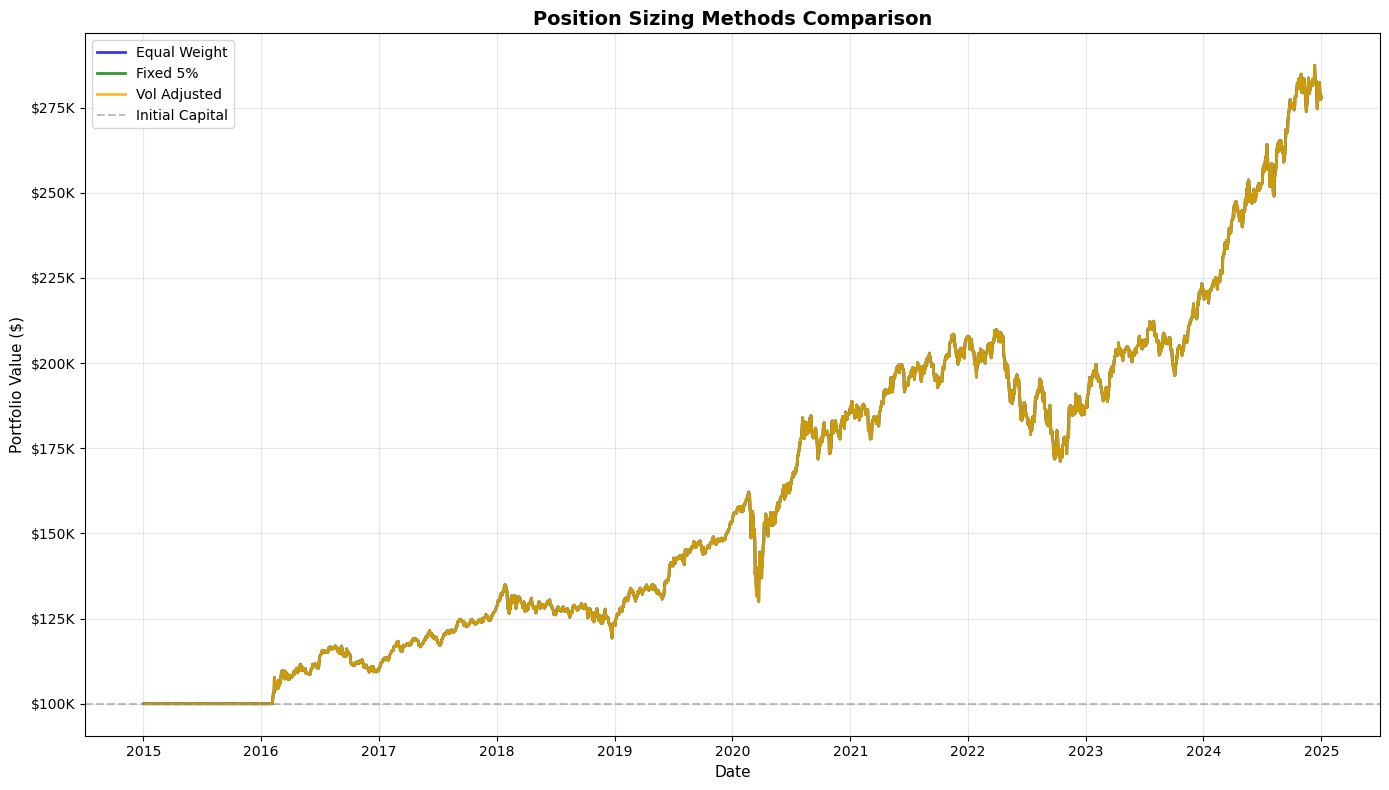

In [9]:
# Plot comparison
fig, ax = plt.subplots(figsize=(14, 8))

colors = ['blue', 'green', 'orange']
for i, (method_name, data) in enumerate(results.items()):
    equity = data['equity_df']
    if 'Date' in equity.columns:
        equity = equity.set_index('Date')
    
    ax.plot(
        equity.index,
        equity['TotalValue'] if 'TotalValue' in equity.columns else equity['Equity'],
        label=method_name,
        linewidth=2,
        color=colors[i],
        alpha=0.8
    )

ax.axhline(y=100000, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
ax.set_title('Position Sizing Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

## Step 8: Summary Comparison Table

In [ ]:
# Create comparison table
comparison_data = []

for method_name, data in results.items():
    metrics = data['metrics']
    comparison_data.append({
        'Method': method_name,
        'Total Return': f"{metrics['Total Return']:.2%}",
        'CAGR': f"{metrics['CAGR']:.2%}",
        'Sharpe': f"{metrics['Sharpe Ratio']:.3f}",
        'Max DD': f"{metrics['Max Drawdown']:.2%}",
        'Volatility': f"{metrics['Annual Volatility']:.2%}",
        'Trades': len(data['trades_df'])
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("POSITION SIZING METHODS COMPARISON")
print("="*80 + "\n")
display(comparison_df)

print("\n💡 Key Insights:")
print("- All methods show similar returns (no risk integration yet)")
print("- Once integrated, vol-adjusted sizing should reduce drawdowns")
print("- Kelly criterion would optimize for growth")
print("- Fixed fraction provides consistent risk exposure")

KeyError: 'Volatility'

## Summary

### What We Demonstrated:

1. ✅ **Multiple Position Sizing Methods**
   - Equal weight, Fixed fraction, Volatility-adjusted
   - Each calculates appropriate position sizes

2. ✅ **Risk Validation**
   - Position size limits enforced
   - Leverage limits checked
   - Drawdown stops triggered

3. ✅ **Risk Metrics Collection**
   - Leverage tracking
   - Position concentration
   - Portfolio volatility
   - Correlation monitoring

4. ✅ **Interactive Dashboards**
   - 6-panel Plotly visualization
   - Summary statistics
   - Violation alerts

### Next Step: Integration

To actually use the RiskManager during backtests:
- Add `risk_manager` parameter to `PortfolioConfig`
- Validate trades before execution
- Use calculated position sizes
- Collect metrics throughout backtest

See the integration plan in `RISK_MANAGEMENT_PHASE1_SUMMARY.md`